In [9]:
pip install -U scikit-learn

In [10]:
# Standard imports
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Set new random seeds
np.random.seed(123)
tf.random.set_seed(123)

In [11]:
# Load and preprocess malaria dataset
malaria_data, info = tfds.load('malaria', split='train', with_info=True)
images = []
labels = []

# Resize to 64x64 instead of 32x32 for better feature extraction
for example in tfds.as_numpy(malaria_data):
    img = resize(example['image'], (64, 64)).astype(np.float32)
    images.append(img)
    labels.append(example['label'])
    if len(images) == 27558:
        break

X_data = np.array(images)
y_data = np.array(labels)

# Split data into training, validation, and test sets (70/15/15)
X_temp, X_te, y_temp, y_te = train_test_split(
    X_data, y_data, test_size=0.15, random_state=123, stratify=y_data)

X_tr, X_va, y_tr, y_va = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=123, stratify=y_temp)  # ≈15% of full data

# Output new shapes
print("Training set shape:", X_tr.shape, y_tr.shape)
print("Validation set shape:", X_va.shape, y_va.shape)
print("Test set shape:", X_te.shape, y_te.shape)

Training set shape: (19289, 64, 64, 3) (19289,)
Validation set shape: (4135, 64, 64, 3) (4135,)
Test set shape: (4134, 64, 64, 3) (4134,)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,vertical_flip=True,horizontal_flip=True)

In [13]:
#CNN-LSTM-LSTM model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[64,64,3]), # Changed input_shape to [64, 64, 3]
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",activation="relu"),
        keras.layers.MaxPool2D(2),
        # Reshaped to (128, -1), allowing the second dimension to be calculated dynamically
        keras.layers.Reshape((128, -1)),

        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(64, return_sequences=True),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 854,350 (3.26 MB)

 Trainable params: 854,344 (3.26 MB)

 Non-trainable params: 6 (24.00 B)

In [14]:
#train model

opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

history = model.fit(datagen.flow(X_tr, y_tr, batch_size=32), epochs=100, validation_data=(X_va, y_va),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.5785 - loss: 0.6763 - val_accuracy: 0.7990 - val_loss: 0.4792
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.8777 - loss: 0.3166 - val_accuracy: 0.9417 - val_loss: 0.1705
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.9440 - loss: 0.1754 - val_accuracy: 0.9555 - val_loss: 0.1349
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9525 - loss: 0.1500 - val_accuracy: 0.9570 - val_loss: 0.1325
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9547 - loss: 0.1410 - val_accuracy: 0.9606 - val_loss: 0.1189
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9532 - loss: 0.1443 - val_accuracy: 0.9577 - val_loss: 0.1324
Epoch 7/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.9550 - loss: 0.1398 - val_accuracy: 0.9603 - val_loss: 0.1285
Epoch 8/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9568 - loss: 0

In [16]:
model.evaluate(X_te, y_te)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9600 - loss: 0.1183


[0.11636807024478912, 0.9571843147277832]

In [17]:
y_pred= np.argmax(model.predict(X_te), axis=1)
y_pred

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


array([0, 1, 0, ..., 0, 1, 0])

In [18]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te,y_pred)
cm

array([[1936,  131],
       [  46, 2021]])

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2067
           1       0.94      0.98      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



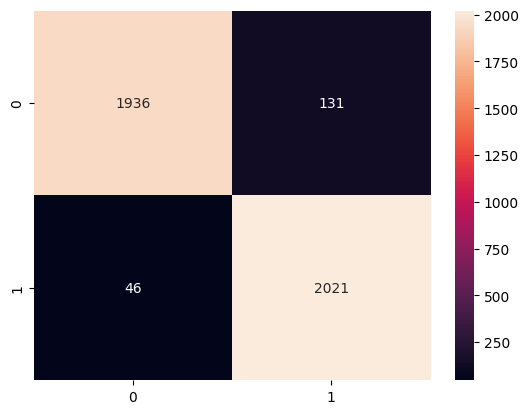

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

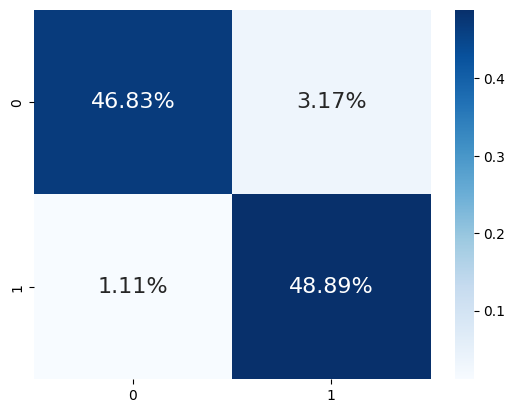

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-LSTM-LSTM.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-LSTM-LSTM.pdf')

In [22]:
#CNN-GRU-GRU model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[64,64,3]), # Change input_shape to match the actual data shape
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),
        keras.layers.Reshape((16, 16*128)), #Explicitly calculate the reshape dimensions

        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(64, return_sequences=True),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16, 128)        │       836,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,670 (3.90 MB)

 Trainable params: 1,022,664 (3.90 MB)

 Non-trainable params: 6 (24.00 B)

In [23]:
#train model
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_tr, y_tr, batch_size=32), epochs=100, validation_data=(X_va, y_va),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.7195 - loss: 0.5119 - val_accuracy: 0.9466 - val_loss: 0.1637
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9381 - loss: 0.1933 - val_accuracy: 0.9429 - val_loss: 0.1742
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9474 - loss: 0.1649 - val_accuracy: 0.9565 - val_loss: 0.1343
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.9530 - loss: 0.1508 - val_accuracy: 0.9591 - val_loss: 0.1243
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9569 - loss: 0.1377 - val_accuracy: 0.9574 - val_loss: 0.1254
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.9564 - loss: 0.1338 - val_accuracy: 0.9603 - val_loss: 0.1214
Epoch 7/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9583 - loss: 0.1283 - val_accuracy: 0.9608 - val_loss: 0.1154
Epoch 8/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.9592 - loss: 0

In [24]:
model.evaluate(X_te, y_te)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9649 - loss: 0.1103


[0.11576339602470398, 0.9617803692817688]

In [25]:
y_pred= np.argmax(model.predict(X_te), axis=1)
y_pred

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


array([0, 1, 0, ..., 0, 1, 0])

In [26]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te,y_pred)
cm

array([[1984,   83],
       [  75, 1992]])

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2067
           1       0.96      0.96      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



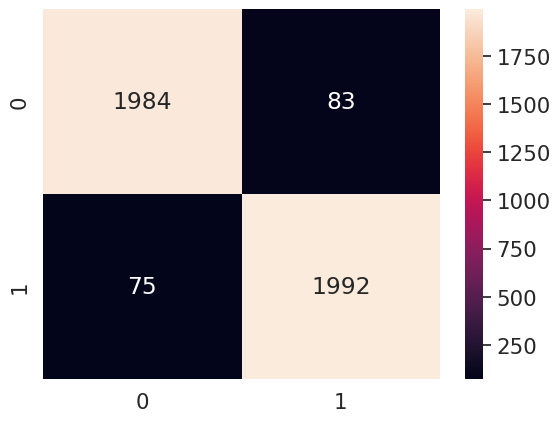

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

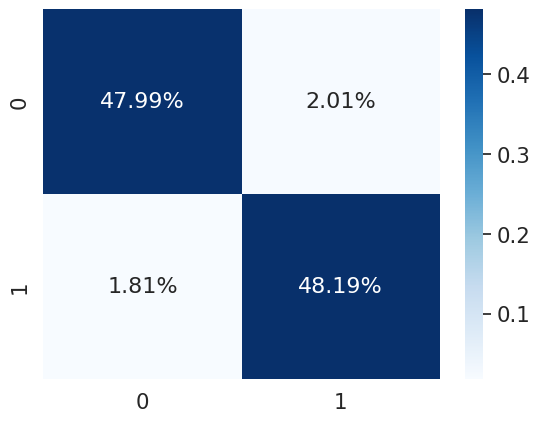

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-GRU-GRU.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-GRU-GRU.pdf')

In [30]:
#CNN-BiLSTM-BiLSTM model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[64,64,3]),
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
        keras.layers.MaxPool2D(2),

        keras.layers.Reshape((16*16, 128)),

        keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,662 (889.30 KB)

 Trainable params: 227,656 (889.28 KB)

 Non-trainable params: 6 (24.00 B)

In [31]:
#train model
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_tr, y_tr, batch_size=32), epochs=100, validation_data=(X_va, y_va),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 49s 76ms/step - accuracy: 0.5752 - loss: 0.6711 - val_accuracy: 0.6680 - val_loss: 0.6247
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.6410 - loss: 0.6385 - val_accuracy: 0.6068 - val_loss: 0.6536
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.6507 - loss: 0.6244 - val_accuracy: 0.7603 - val_loss: 0.5180
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.8272 - loss: 0.4101 - val_accuracy: 0.5845 - val_loss: 0.6855
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.5674 - loss: 0.6798 - val_accuracy: 0.5831 - val_loss: 0.6753
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.5870 - loss: 0.6738 - val_accuracy: 0.6314 - val_loss: 0.6404
Epoch 7/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.6361 - loss: 0.6434 - val_accuracy: 0.6239 - val_loss: 0.6581
Epoch 8/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.6252 - loss: 0

In [32]:
model.evaluate(X_te, y_te)

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6394 - loss: 0.6350


[0.6274424195289612, 0.650943398475647]

In [33]:
y_pred= np.argmax(model.predict(X_te), axis=1)
y_pred

130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


array([1, 1, 0, ..., 1, 0, 0])

In [34]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te,y_pred)
cm

array([[1310,  757],
       [ 686, 1381]])

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64      2067
           1       0.65      0.67      0.66      2067

    accuracy                           0.65      4134
   macro avg       0.65      0.65      0.65      4134
weighted avg       0.65      0.65      0.65      4134



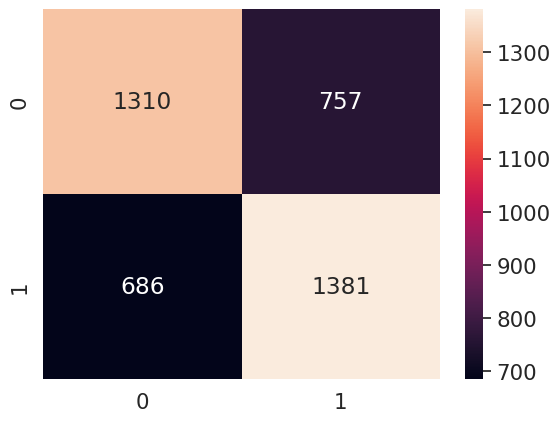

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

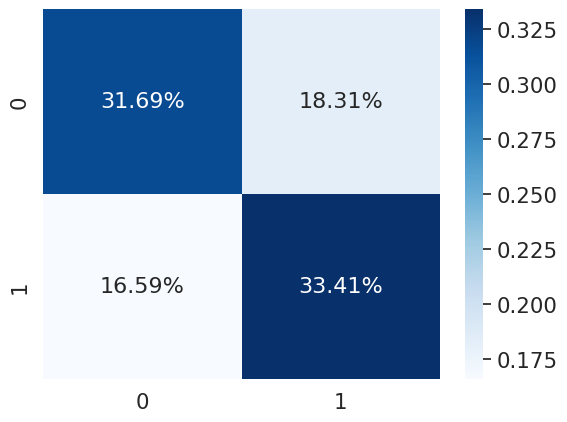

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-BiLSTM-BiLSTM.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-BiLSTM-BiLSTM.pdf')